In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import cv2
import datetime

In [2]:
import pywt
n = 2
w = 'db1'

In [3]:
from sklearn.linear_model import Lasso

In [4]:
def idct2(x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

alpha=1E-4
max_iter=1E3

In [5]:
def make_noisy(frame, noise):
    if noise == 0.0:
        frame = frame
    else:
        try:
            0.0 <= noise < 1.0
        except ValueError:
            print(f"Value of noise has to be in range [0,1). Got noise={noise}")
        noisemask = np.random.choice(a=[False, True], size=frame.shape, p=[noise, 1.0-noise])
        frame = noisemask * frame
    return frame

In [6]:
image = imread('../dog.jpg')
bw_image = np.mean(image, -1); # Convert RGB to grayscale

(-0.5, 1499.5, 1999.5, -0.5)

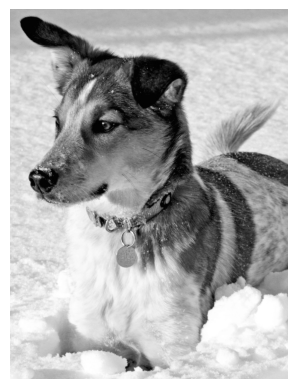

In [7]:
plt.figure()
plt.imshow(bw_image,cmap='gray')
plt.axis('off')

In [8]:
# square_image = squarify(bw_image)
# plt.figure()
# plt.imshow(square_image,cmap='gray')
# plt.axis('off')
square_image = bw_image

(-0.5, 31.5, 31.5, -0.5)

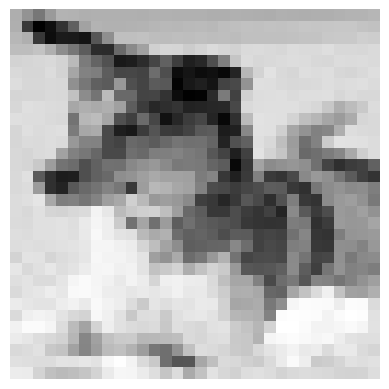

In [9]:
height = 32
width = 32

resized_image = cv2.resize(square_image, (width, height), interpolation=cv2.INTER_AREA)
plt.figure()
plt.imshow(resized_image,cmap='gray')
plt.axis('off')

(-0.5, 31.5, 31.5, -0.5)

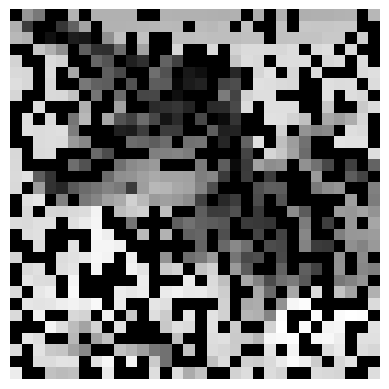

In [10]:
noise = 0.4

noisyframe = make_noisy(resized_image, noise)
plt.figure()
plt.imshow(noisyframe,cmap='gray')
plt.axis('off')

In [ ]:
ny, nx = noisyframe.shape

In [22]:
coeffs_1D = pywt.dwt(np.eye(nx*ny),wavelet=w)

In [25]:
coeffs_1D[0].shape

(1024, 512)

In [26]:
coeffs_1D[1].shape

(1024, 512)

In [ ]:
coeffs = pywt.wavedec2(np.eye(nx*ny),wavelet=w,level=n)
coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

In [12]:
coeff_arr.shape

(1024, 1024)

In [13]:
coeff_slices

[(slice(None, 256, None), slice(None, 256, None)),
 {'ad': (slice(None, 256, None), slice(256, 512, None)),
  'da': (slice(256, 512, None), slice(None, 256, None)),
  'dd': (slice(256, 512, None), slice(256, 512, None))},
 {'ad': (slice(None, 512, None), slice(512, 1024, None)),
  'da': (slice(512, 1024, None), slice(None, 512, None)),
  'dd': (slice(512, 1024, None), slice(512, 1024, None))}]

In [14]:
flat_frame = noisyframe.T.reshape(-1,1)
idx_nonzero = np.where(flat_frame != 0)[0]

In [15]:
lasso = Lasso(alpha=alpha, max_iter=int(max_iter), warm_start=True, selection="random")


In [16]:
# compressed sample
b = flat_frame[idx_nonzero]
# compression matrix @ transform matrix
Ac = coeff_arr[idx_nonzero, :]
# Ac = A[idx_nonzero,:]

# LASSO optimization
lasso.fit(Ac, b)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.023e+02, tolerance: 2.395e+02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0001, selection='random', warm_start=True)

In [19]:
# Reconstruct frame
coeff_recon = np.array(lasso.coef_)

In [20]:
coeff_recon.shape

(1024,)

In [34]:
coeffs_filt = pywt.array_to_coeffs(coeff_recon,coeff_slices,output_format='wavedec2')

In [35]:
Arecon = pywt.waverec2(coeffs_filt,wavelet=w)

ValueError: All detail shapes must be the same length.

In [ ]:
# # Reconstruct frame
# coeff = np.array(lasso.coef_)
# reconstructed_image = np.array(sympy.fwht(coeff)).astype(np.float32).reshape(width,height).T

In [39]:
coeff_slices

[(slice(None, 4096, None), slice(None, 4096, None)),
 {'ad': (slice(None, 4096, None), slice(4096, 8192, None)),
  'da': (slice(4096, 8192, None), slice(None, 4096, None)),
  'dd': (slice(4096, 8192, None), slice(4096, 8192, None))},
 {'ad': (slice(None, 8192, None), slice(8192, 16384, None)),
  'da': (slice(8192, 16384, None), slice(None, 8192, None)),
  'dd': (slice(8192, 16384, None), slice(8192, 16384, None))}]